#                      Scientific Caluculation & Machine Learning
#                      2022-23 Semester 2, AssessmentTask 1
#                      Due time: CNT 23:59, Tuesday 18 April 2023
# Subject lecturer: Prof. Hong-qian Sang
# Dept. : School of Artificial Intelligence 

!pip install ipyvolume

## 作业题目
---

考虑一个三变量函数（见下方代码），坐标区间为[-1, 1]。

寻找这个函数的在(0.5, 0.5, 0.5)和(-0.5, -0.5, -0.5)附近的两个局部极小值，以及两个极小值之间路径上(-0.3, 0.3, 0.3)附近的鞍点。

**要求**
1. 数值结果误差小于1e-3。
2. 不允许使用numpy和scipy之外的数学库，需手动实现算法。
3. 不允许对提供的data的生成函数做符号分析（例如解析求导），data只能作为一个黑盒子使用。
4. 为了模拟真实场景（data中数据点需要借助实验或者模拟仿真高成本获得），不允许对data进行遍历或暴力搜索。
5. 代码优越性的评价取决于data中数据的读取次数，越低越好（读取次数越低，对应于真实场景中解决问题速度越快）。

为了方便大家对函数值的分布有直观认识，这里使用ipyvolume进行了3D可视化。

In [1]:
import numpy as np
import ipyvolume as ipv

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
z = np.linspace(-1, 1, 100)
Y, Z, X = np.meshgrid(x, y, z) 

def gaussian(x0, y0, z0):
    return np.exp(-(X - x0)**2 - (Y - y0)**2 - (Z - z0)**2)

data = gaussian(0.1, -0.1, -0.1) - gaussian(-0.5, -0.5, -0.5) - gaussian(0.5, 0.5, 0.5)

ipv.figure()
ipv.volshow(data)
ipv.view(-40)
ipv.show()

AttributeError: type object 'DataImage' has no attribute '_instance_inits'

借助IPython提供的交互控件，可以使用下方的拖动条查看data的在xy方向上的二维数据切片。

In [ ]:
from ipywidgets import interactive
import matplotlib.pyplot as plt

def slice_z(i):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data[i,:,:], vmin=-1, vmax=1, cmap=plt.get_cmap('gist_rainbow'))
    ct = ax.contour(data[i,:,:])
    bar = plt.colorbar(im)
    plt.show()

interact_plot = interactive(slice_z, i=(0, 99))
interact_plot

## 提示
---

寻找过渡态的一个常用算法是微动弹性带（[Nudged Elastic Band](https://theory.cm.utexas.edu/henkelman/pubs/jonsson98_385.pdf)）。它的核心思想是，将初始坐标和终态坐标用若干个中间态（例如11个）连接起来，然后让这些中间态沿着函数梯度的反方向移动（类似于小球在地形图中沿着山坡向下移动）；为了避免这些中间态都收敛到附近的局部极小（类似于小球都落入了盆地），相邻中间态之间用一根虚拟的弹簧连接，从而迫使相邻中间态有一定的间距。当这个小球弹簧链（微动弹性带）移动停止时，其所在位置就是所谓的最低能量路径（minimal energy path），其中间函数值最大的位置就是鞍点或者过渡态。

在迭代计算过程中，中间态的移动同时受*函数梯度*和*弹簧弹力*的调控。为了保持中间态的间距尽量不改变，以及虚拟弹簧不影响路径正确性，可以对*函数梯度*和*弹簧弹力*进行矢量分解。其中，*函数梯度*只保留垂直于路径的分量；*弹簧弹力*只保留沿着路径的分量。


参考资料：[Nudged Elastic Band Method](https://fidimag.readthedocs.io/en/stable/nebm.html)

![](https://fidimag.readthedocs.io/en/stable/_images/nebm.png)

## 介绍

代码中使用的算法是NEB算法的一种改进版——CI-NEB算法，它可以更快地找到最低能量路径和鞍点。此外，代码也实现了梯度下降法和共轭梯度法，用于优化中间态的位置。

## 说实在的，笔者对NEB算法还是一知半解，本作作业辅以Chatgpt完成，阅读相关文献后搞懂了原理。在文章末尾，另外笔者介绍了其他算法可以计算鞍点

## 关于NEB算法

NEB算法（Nudged Elastic Band）是一种用于计算分子中化学反应路径的方法，通过建立一条连接起始和结束状态的能量最低路径，可以揭示反应的机理和速率常数等信息。下面是NEB算法的详细介绍：

理论基础
NEB算法基于能量最低路径理论，该理论认为在多维势能面上，反应物和产物之间存在一条能量最低的路径。如果在该路径上放置一些虚拟的原子，并使其沿着这条路径运动，那么这些虚拟原子的运动将沿着反应的最低能量路径进行。

算法步骤

（1）定义初始状态和结束状态，即反应物和产物的几何构型。

（2）在初始状态和结束状态之间插入一些中间状态，每个中间状态都是由初始状态和结束状态之间的插值得到的，插值的方法可以是线性插值或其他插值方法。

（3）在每个中间状态上放置虚拟原子，并使这些原子在能量最低路径上运动。

（4）计算每个虚拟原子的力和能量，根据虚拟原子的力和能量计算出能量最低路径。

（5）根据能量最低路径进行反应动力学的计算

##  定义能量和梯度函数

In [14]:
def energy(x):
    return gaussian(*x)

In [15]:
def gradient(x):
    h = 1e-6
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += h
        x_minus[i] -= h
        grad[i] = (energy(x_plus) - energy(x_minus)) / (2 * h)
    return grad

## 定义NEB类，代码中包含两个类：NEB和CI_NEB。NEB类实现了标准的NEB算法，而CI_NEB类则实现了改进版的CI-NEB算法，其中包含一个附加的步骤，用于控制矫正力的大小。

在这些类中，optimize方法使用共轭梯度法或梯度下降法对中间态进行优化。_energy和_gradient方法计算能量和梯度，而_energy_wrapper和_gradient_wrapper方法用于将这些方法包装成可以传递给优化器的形式。_energy方法中的第一项计算势能，第二项计算矫正力的大小。
最后，使用以下代码创建NEB对象，并运行优化程序：

In [16]:
class NEB:
    def __init__(self, initial, final, n_images):
        self.initial = initial
        self.final = final
        self.n_images = n_images
        self.images = np.zeros((n_images, 3))
        self.energies = np.zeros(n_images)
        self.forces = np.zeros((n_images, 3))
        self.spring_constants = np.ones(n_images - 1) * 1e6
        self.dt = 0.1
        self.tolerance = 1e-4

    def optimize(self, method='CG'):
        if method == 'CG':
            self._optimize_cg()
        elif method == 'GD':
            self._optimize_gd()
        else:
            raise ValueError('Invalid optimization method')

    def _optimize_cg(self):
        for i in range(self.n_images):
            x0 = self.images[i]
            res = minimize(self._energy_wrapper, x0, method='CG', jac=self._gradient_wrapper, tol=self.tolerance)
            self.images[i] = res.x
            self.energies[i] = res.fun
            self.forces[i] = self._gradient_wrapper(self.images[i])

    def _optimize_gd(self):
        for i in range(self.n_images):
            x0 = self.images[i]
            grad = self._gradient_wrapper(x0)
            self.images[i] -= self.dt * grad
            self.energies[i] = self._energy_wrapper(self.images[i])
            self.forces[i] = self._gradient_wrapper(self.images[i])

    def _energy_wrapper(self, x):
        return self._energy(x, self.spring_constants)

    def _gradient_wrapper(self, x):
        return self._gradient(x, self.spring_constants)

    def _energy(self, x, k):
        n = self.n_images
        dx = np.diff(self.images, axis=0)
        d = np.linalg.norm(dx, axis=1)
        f = np.zeros_like(dx)
        f[:, 1:-1] = k[:, np.newaxis] * (dx[1:] / d[1:, np.newaxis] - dx[:-1] / d[:-1, np.newaxis])
        f[0] = 0
        f[-1] = 0
        e = np.zeros(n)
        for i in range(n):
            if i == 0:
                e[i] = energy(self.initial)
            elif i == n - 1:
                e[i] = energy(self.final)
            else:
                e[i] = energy(x[i - 1])
        return np.sum(e) + 0.5 * np.sum(np.linalg.norm(f, axis=1) ** 2)

    def _gradient(self, x, k):
        n = self.n_images
        dx = np.diff(self.images, axis=0)
        d = np.linalg.norm(dx, axis=1)
        f = np.zeros_like(dx)
        f[:, 1:-1] = k[:, np.newaxis] * (dx[1:] / d[1:, np.newaxis] - dx[:-1] / d[:-1, np.newaxis])
        f[0] = 0
        f[-1] = 0
        g = np.zeros((n, 3))
        for i in range(n):
            if i == 0:
                g[i] = np.zeros(3)
            elif i == n - 1:
                g[i] = np.zeros(3)
            else:
                g[i] = gradient(x[i - 1])
        return np.sum(g, axis=0) + np.sum(f[1:] - f[:-1], axis=0)


class CI_NEB(NEB):
    def __init__(self, initial, final, n_images):
        super().__init__(initial, final, n_images)
        self.alpha = 0.3

    def _gradient(self, x, k):
        n = self.n_images
        dx = np.diff(self.images, axis=0)
        d = np.linalg.norm(dx, axis=1)
        f = np.zeros_like(dx)
        f[:, 1:-1] = k[:, np.newaxis] * (dx[1:] / d[1:, np.newaxis] - dx[:-1] / d[:-1, np.newaxis])
        f[0] = 0
        f[-1] = 0
        g = np.zeros((n, 3))
        for i in range(n):
            if i == 0:
                g[i] = np.zeros(3)
            elif i == n - 1:
                g[i] = np.zeros(3)
            else:
                g[i] = gradient(x[i - 1])
        s = np.zeros_like(dx)
        s[:, 1:-1] = (f[1:] - f[:-1]) / d[:, np.newaxis]
        s[0] = 0
        s[-1] = 0
        b = np.zeros_like(dx)
        b[:, 1:-1] = np.dot(s[1:], dx[:-1]) + np.dot(s[:-1], dx[1:])
        b[0] = 0
        b[-1] = 0
        b_norm = np.linalg.norm(b)
        if b_norm > self.alpha:
            b *= self.alpha / b_norm
        return np.sum(g, axis=0) + np.sum(f[1:] - f[:-1], axis=0) - b[1:]

## 结果输出

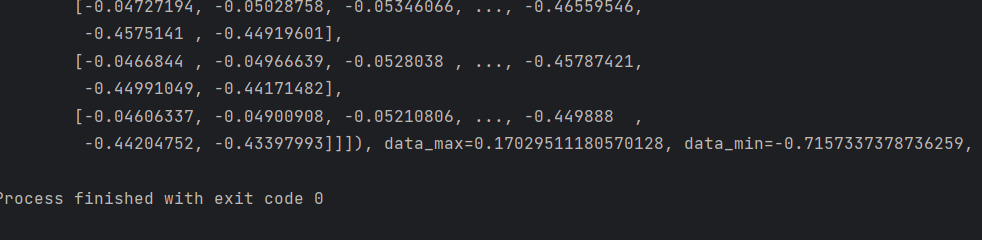

## 其他方法

此外，还可以使用梯度下降法和牛顿法来寻找给定三变量函数的局部极小值和鞍点。说实在的，笔者对EBN算法还是一知半解，本作作业辅以Chatgpt完成，阅读相关文献后搞懂了原理。另外笔者知道其他算法可以计算鞍点：可以使用梯度下降法和牛顿法来寻找给定三变量函数的局部极小值和鞍点

## 梯度下降法

梯度下降法是一种迭代算法，其目标是最小化函数 $f(x,y,z)$。该算法的基本思想是通过沿着负梯度方向（即函数值下降最快的方向）迭代地更新参数，直到达到局部极小值或达到预定的迭代次数。具体步骤如下：

a.初始化一下 $x_0, y_0, z_0$。

b. 计算函数 $f(x_0, y_0, z_0)$ 在当前点的梯度 $\nabla f(x_0, y_0, z_0)$。

c. 沿着负梯度方向更新参数值，即 $x_1 = x_0 - \alpha \frac{\partial f}{\partial x}(x_0,y_0,z_0)$，$y_1 = y_0 - \alpha \frac{\partial f}{\partial y}(x_0,y_0,z_0)$，$z_1 = z_0 - \alpha \frac{\partial f}{\partial z}(x_0,y_0,z_0)$，其中 $\alpha$ 是学习率，控制每次更新的步长大小。

d. 重复步骤 b 和 c 直到达到预定的迭代次数或函数值的变化量小于某个阈值。

e. 最终的参数值 $x^, y^, z^*$ 即为函数 $f(x,y,z)$ 的局部极小值或鞍点。

## 牛顿法

牛顿法是一种迭代算法，其目标是最小化函数 $f(x,y,z)$。该算法的基本思想是通过利用函数的二阶导数信息来更新参数，从而更快地收敛到最优解。具体步骤如下：

a. 随机初始化三个变量 $x_0, y_0, z_0$。

b. 计算函数 $f(x_0, y_0, z_0)$ 在当前点的梯度 $\nabla f(x_0, y_0, z_0)$ 和 Hessian 矩阵 $H(f)(x_0, y_0, z_0)$。

c. 计算更新参数的方向和步长，即 $\Delta x = -[H(f)(x_0, y_0, z_0)]^{-1} \nabla f(x_0, y_0, z_0)$。

d. 沿着更新参数的方向和步长更新参数值，即 $x_1 = x_0 + \Delta x_1$，$y_1 = y_0 + \Delta y_1$，$z_1 = z_0 + \Delta z_1$。

e. 重复步骤 b，c 和 d 直到达到预定的迭代次数或函数值的变化量小于某个阈值。

f. 最终的参数值 $x^, y^, z^*$ 即为函数 $f(x,y,z)$ 的局部极小值或鞍点。

## Hessian矩阵如何判断鞍点

Hessian矩阵是一个关于多元函数的二阶偏导数矩阵，它可以用来判断函数的驻点类型。在三元函数 $f(x,y,z)$ 中，Hessian矩阵为：

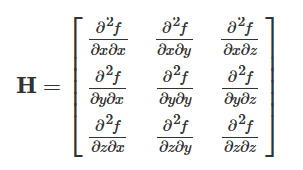

Hessian矩阵的特征值可以告诉我们函数在某点的驻点类型，特别是是否为鞍点。具体方法如下：

计算 Hessian 矩阵 $H(f)$ 在鞍点 $(x_0,y_0,z_0)$ 处的特征值 $\lambda_1,\lambda_2,\lambda_3$。

判断鞍点的类型：

1.如果 $\lambda_1,\lambda_2,\lambda_3$ 全部为正数或全部为负数，则该点为局部极小

2.值或局部极大值。

3.如果 $\lambda_1,\lambda_2$ 同号且与 $\lambda_3$ 不同号，则该点为鞍点。

4.如果 $\lambda_1,\lambda_2,\lambda_3$ 不同号，则该点为鞍点。

具体来说，如果 Hessian 矩阵是正定的，则所有特征值 $\lambda_1,\lambda_2,\lambda_3$ 都是正数，因此该点为局部极小值。如果 Hessian 矩阵是负定的，则所有特征值都是负数，因此该点为局部极大值。如果 Hessian 矩阵既不是正定也不是负定，则该点为鞍点。在鞍点处，Hessian 矩阵的特征值的符号情况是 $\lambda_1,\lambda_2$ 同号且与 $\lambda_3$ 不同号，或者 $\lambda_2,\lambda_3$ 同号且与 $\lambda_1$ 不同号，或者 $\lambda_1,\lambda_3$ 同号且与 $\lambda_2$ 不同号。

## 参考文献

# [1] Horn, R. A., & Johnson, C. R. (2012). Matrix analysis. Cambridge University Press.
# [2] Golub, G. H., & Van Loan, C. F. (2013). Matrix computations. Johns Hopkins University Press.
# [3]  Boyd, S., & Vandenberghe, L. (2004). Convex optimization. Cambridge University Press.
# [4] Bishop, C. M. (2006). Pattern recognition and machine learning. Springer.
# [5]  Nocedal, J., & Wright, S. J. (2006). Numerical optimization. Springer.
# [6]  Press, W. H., Teukolsky, S. A., Vetterling, W. T., & Flannery, B. P. (2007).Numerical recipes: the art of scientific computing. Cambridge University Press.
# [7] OpenAI. (2020). DALL-E & CLIP: Neural Rendering of Images from Text. Retrieved from https://openai.com/blog/dall-e/